In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
numpy = lambda x: x.detach().cpu().numpy()

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from geomloss import SamplesLoss
from pykeops.torch import LazyTensor

In [3]:
import sys
sys.path.append('../')
from src import utils, RWSampler, Inference, dataloader

In [11]:
def cost_function(ytrue_w, ytrue, ypred_w, ypred):

    D_w  = (ytrue_w[:, :] @ (ypred_w[:, :]).transpose(0, 1))[:, :, None]
    C_ij = ((ytrue[:,  None,:] - ypred[None,:,:]) ** 2).sum(-1) / 2
    C_ij = C_ij[:, :, None]  # reshape as a (N, M, 1) Tensor
    C_ij = C_ij*D_w

    return C_ij
    
loss = SamplesLoss(loss="sinkhorn", cost = cost_function(ytrue_w, ytrue, ypred_w, ypred), p=2, blur=.05) 

In [12]:
loss

SamplesLoss()

### Simulated Data 

In [4]:
ytrue = torch.tensor([1.2, 2.3, 3.4, 4.1, 5.3, 6.5, 6.7, 7.1, 
                    7.5, 7.9, 8.2, 8.3, 8.6, 9.1, 9.3, 9.5, 
                    9.7, 10.2, 10.3, 10.5, 10.6, 11.2, 11.6, 11.7, 
                    11.9, 12.2, 12.4, 12.5, 12.7, 12.9, 12.95, 13.1, 
                    13.3, 13.5, 13.7, 13.9, 14.7, 14.8, 14.9, 15.2,
                    15.5, 16.1, 16.5, 17.1, 17.7, 18.7, 18.9, 19.1, 
                    19.5, 20.8, 20.9, 21.1, 21.5, 22.5, 22.6, 23.4, 
                    23.6, 24.7, 24.0, 25.7, 26.8, 27.5, 28.3, 29.8], dtype=torch.float32).reshape((64,1))

ypred = torch.tensor([8.2, 8.3, 8.4, 9.1, 9.3, 9.5, 8.7, 9.1, 
                    10.5, 10.9, 11.2, 11.3, 11.6, 9.1, 9.3, 9.5, 
                    9.7, 10.2, 10.3, 10.5, 10.6, 11.2, 11.6, 11.7, 
                    11.9, 12.2, 12.4, 12.5, 12.7, 12.9, 12.95, 13.1, 
                    13.3, 13.5, 13.7, 13.9, 14.7, 14.8, 14.9, 15.2,
                    15.5, 15.1, 12.5, 14.1, 15.7, 13.7, 14.9, 15.1, 
                    15.5, 12.8, 12.9, 11.1, 11.5, 12.5, 12.6, 13.4, 
                    13.6, 14.7, 14.0, 15.7, 16.8, 17.5, 19.3, 19.8], dtype=torch.float32).reshape((64,1))

'''y_j = torch.tensor([8.2, 8.3, 8.4, 9.1, 9.3, 9.5, 8.7, 9.1, 
                    10.5, 10.9, 11.2, 11.3, 11.6, 9.1, 9.3, 9.5, 
                    9.7, 10.2, 10.3, 10.5, 10.6, 11.2, 11.6, 11.7, 
                    11.9, 12.2, 12.4, 12.5, 12.7, 12.9, 12.95, 13.1, 
                    13.3, 13.5, 13.7, 13.9, 14.7, 14.8, 14.9, 15.2,
                    15.5, 15.1, 12.5, 14.1, 15.7, 13.7, 14.9, 15.1, 
                    15.5, 12.8, 12.9, 11.1, 11.5, 12.5, 12.6, 13.4, 
                    13.6, 14.7, 14.0, 15.7, 16.8, 17.5, 19.3, 19.8], dtype=torch.float32).reshape((64,1))'''

'y_j = torch.tensor([8.2, 8.3, 8.4, 9.1, 9.3, 9.5, 8.7, 9.1, \n                    10.5, 10.9, 11.2, 11.3, 11.6, 9.1, 9.3, 9.5, \n                    9.7, 10.2, 10.3, 10.5, 10.6, 11.2, 11.6, 11.7, \n                    11.9, 12.2, 12.4, 12.5, 12.7, 12.9, 12.95, 13.1, \n                    13.3, 13.5, 13.7, 13.9, 14.7, 14.8, 14.9, 15.2,\n                    15.5, 15.1, 12.5, 14.1, 15.7, 13.7, 14.9, 15.1, \n                    15.5, 12.8, 12.9, 11.1, 11.5, 12.5, 12.6, 13.4, \n                    13.6, 14.7, 14.0, 15.7, 16.8, 17.5, 19.3, 19.8], dtype=torch.float32).reshape((64,1))'

In [5]:
### Generating weights based on weight dense approach 
weights = RWSampler.TargetRelevance(np.array(ytrue), alpha = 2.0).__call__(np.array(ytrue)).ravel()
weights = np.where(weights >= 1, weights, 1)
weights

array([8.86034317, 7.14162456, 5.06996017, 3.56102322, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.05433613, 1.26385723, 2.50278815, 1.68938739, 3.77395198,
       5.24006276, 6.19565509, 7.28636126, 9.24076768])

In [7]:
ytrue_w = torch.tensor(weights) #torch.full((64,), 1.0)
ypred_w = torch.tensor(weights) #torch.full((64,), 1.0)

In [8]:
ytrue_w = ytrue_w.unsqueeze(dim = 0)
ytrue_w = torch.cat((ytrue_w, ytrue_w), dim = 0)
ypred_w = ypred_w.unsqueeze(dim = 0)
ypred_w = torch.cat((ypred_w, ypred_w), dim = 0)

ytrue = ytrue.unsqueeze(dim = 0)
ytrue = torch.cat((ytrue, ytrue), dim = 0)
ypred = ypred.unsqueeze(dim = 0)
ypred = torch.cat((ypred, ypred), dim = 0)

print(f"{ytrue_w.shape} | {ytrue.shape} | {ypred_w.shape} | {ypred.shape}")

torch.Size([2, 64]) | torch.Size([2, 64, 1]) | torch.Size([2, 64]) | torch.Size([2, 64, 1])


In [6]:
def return_bins_count(yture, w): 
        
        df = pd.DataFrame()
        df['ytrue'] = yture
        df['weights'] = w
        weight_means = []
        for i in range(30):
                if i == 0:
                        yture_count = df.loc[(df['ytrue'] >= i) & (df['ytrue'] <= (i+1))]
                        weight_mean = df['weights'].loc[(df['ytrue'] >= i) & (df['ytrue'] <= (i+1))].mean()

                else: 
                        yture_count = df.loc[(df['ytrue'] > i) & (df['ytrue'] <= (i+1))] 
                        weight_mean = df['weights'].loc[(df['ytrue'] > i) & (df['ytrue'] <= (i+1))].mean()

                weight_means.append(weight_mean)
        return weight_means


weight_means = return_bins_count(np.array(ytrue).ravel(), weights)
weight_means = np.array(weight_means)
weight_means = np.where(weight_means < 1, 1, weight_means) 

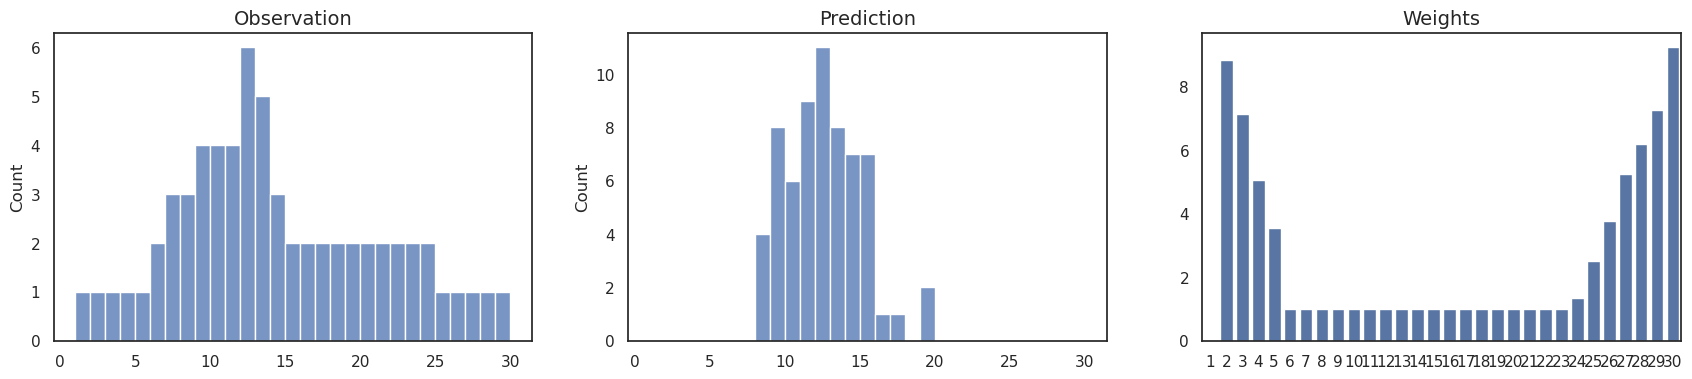

In [7]:
fig, axs = plt.subplots(1, 3 , figsize = (21, 4))

sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams["figure.autolayout"] = True
plt.subplots_adjust(hspace = 0.01)

bins_value  = np.arange(1, 31, 1)
ax1 = sns.histplot(np.array(ytrue).ravel(), bins = bins_value,  ax = axs[0]) 
ax1.set_title("Observation", fontsize = 14)

ax2 = sns.histplot(np.array(ypred).ravel(), bins = bins_value, ax = axs[1]) 
ax2.set_title("Prediction", fontsize = 14)

ax3 = sns.barplot(x = bins_value, y = weight_means, color = sns.color_palette()[0],  ax = axs[2])
ax3.set_title("Weights", fontsize = 14)
None

### Wasserstien Calculation 
a quadratic ground cost function: 
$\text{C}(x,y) = \tfrac{1}{2}\|x-y\|^2$

More precisely: having loaded and represented our 3D meshes
as discrete probability measures

\begin{align}\alpha ~=~ \sum_{i=1}^N \alpha_i\,\delta_{x_i}, ~~~
  \beta  ~=~ \sum_{j=1}^M \beta_j\,\delta_{y_j},\end{align}

with **one weighted Dirac mass per triangle**, we will strive to solve the primal-dual entropic OT problem:

\begin{align}\text{OT}_\varepsilon(\alpha,\beta)~&=~
      \min_{0 \leqslant \pi \ll \alpha\otimes\beta} ~\langle\text{C},\pi\rangle
          ~+~\varepsilon\,\text{KL}(\pi,\alpha\otimes\beta) \quad\text{s.t.}~~
       \pi\,\mathbf{1} = \alpha ~~\text{and}~~ \pi^\intercal \mathbf{1} = \beta\\
   &=~ \max_{f,g} ~~\langle \alpha,f\rangle + \langle \beta,g\rangle
        - \varepsilon\langle \alpha\otimes\beta,
          \exp \tfrac{1}{\varepsilon}[ f\oplus g - \text{C} ] - 1 \rangle\end{align}

as fast as possible, optimizing on **dual vectors**:

\begin{align}F_i ~=~ f(x_i), ~~~ G_j ~=~ g(y_j)\end{align}

that encode an implicit transport plan:

\begin{align}\pi ~&=~ \exp \tfrac{1}{\varepsilon}( f\oplus g - \text{C})~\cdot~ \alpha\otimes\beta,\\
  \text{i.e.}~~\pi_{x_i \leftrightarrow y_j}~&=~ \exp \tfrac{1}{\varepsilon}( F_i + G_j - \text{C}(x_i,y_j))~\cdot~ \alpha_i \beta_j.\end{align}

### Computing the entropic Wasserstein distance

Computing the transport cost, assuming that the dual vectors satisfy
the equations at optimality:

\begin{align}\text{OT}_\varepsilon(\alpha,\beta)~=~ \langle \alpha, f^\star\rangle + \langle \beta, g^\star \rangle.\end{align}

Compute the "entropic Wasserstein distance"

\begin{align}\text{D}_\varepsilon(\alpha,\beta)~=~ \sqrt{2 \cdot \text{OT}_\varepsilon(\alpha,\beta)},\end{align}

which is **homogeneous to a distance on the ambient space** and is
associated to the (biased) Sinkhorn cost $\text{OT}_\varepsilon$
with cost $\text{C}(x,y) = \tfrac{1}{2}\|x-y\|^2$.


In [45]:
def custom_wasserstien_loss(ytrue_w, ytrue, ypred_w, ypred, blur: float, sinkhorn_nits: int, weighted_cost_func: True):


    # Compute the logarithm of the weights (needed in the softmin reduction) ---
    loga_i = torch.empty((ytrue_w.shape[0], ytrue_w.shape[1]), dtype = torch.float32) #requires_grad = True, 
    logb_j = torch.empty((ytrue_w.shape[0], ytrue_w.shape[1]), dtype = torch.float32) #requires_grad = True, 

    for b in range(ytrue_w.shape[0]):

        this_loga_i, this_logb_j = ytrue_w[b, :].log(), ypred_w[b, :].log()
        loga_i[b, :] = this_loga_i
        logb_j[b, :] = this_logb_j

    loga_i, logb_j = loga_i[:, :, None, None], logb_j[:, None, :, None]


    if weighted_cost_func is True: 
        W_true = ytrue_w[:, :, None]
        W_pred = ypred_w[:, :, None]

        D_w = W_true @ W_pred.transpose(1, 2)
        D_w = D_w[:, :, :, None]
        C_ij = ((ytrue[:, :,None,:] - ypred[:, None,:,:]) ** 2).sum(-1) / 2
        C_ij = C_ij[:, :, :, None]  # reshape as a (N, M, 1) Tensor
        C_ij = C_ij*D_w

    else: 
        C_ij = ((ytrue[:,None,:] - ypred[None,:,:]) ** 2).sum(-1) / 2
        C_ij = C_ij[:, :, None]  # reshape as a (N, M, 1) Tensor

    # Setup the dual variables -------------------------------------------------
    eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
    F_i, G_j = torch.zeros_like(loga_i), torch.zeros_like(
        logb_j
    )  # (scaled) dual vectors

    # Sinkhorn loop = coordinate ascent on the dual maximization problem -------
    for _ in range(sinkhorn_nits):
        F_i = -((-C_ij / eps + (G_j + logb_j))).logsumexp(dim=2)[:, :, None, :]
        G_j = -((-C_ij / eps + (F_i + loga_i))).logsumexp(dim=1)[:, None, :, :]

    # Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
    F_i_out, G_j_out = eps * F_i, eps * G_j

    list_batch_loss = torch.empty(ytrue.shape[0], dtype = torch.float32)
    for b in range(ytrue_w.shape[0]):
        F_i, G_j = F_i_out[b, ...].view(-1), G_j_out[b, ...].view(-1)
        # Returns the entropic transport cost associated to the dual variables F_i and G_j.''ArithmeticError
        entropic_transport_cost = ytrue_w[b, ...].dot(F_i) + ypred_w[b, ...].dot(G_j)
        loss = (2 * entropic_transport_cost).sqrt()
        list_batch_loss[b] = loss
    
    return list_batch_loss

In [46]:
loss_out_withW = custom_wasserstien_loss(ytrue_w, ytrue, ypred_w, ypred, blur = 0.01, sinkhorn_nits = 100, weighted_cost_func = True)
loss_out_withW

loha_i: torch.Size([2, 64, 1, 1]) | logb_j: torch.Size([2, 1, 64, 1])
C_ij: torch.Size([2, 64, 64, 1])
Fi: torch.Size([2, 64, 1, 1]) | Gj: torch.Size([2, 1, 64, 1]) | weight: torch.Size([2, 64])
Fi: torch.Size([64]) | Gj: torch.Size([64]) | weight: torch.Size([2, 64])
Fi: torch.Size([64]) | Gj: torch.Size([64]) | weight: torch.Size([2, 64])


tensor([210.0436, 210.0436])

In [28]:
def custom_wasserstien_loss(ytrue_w, ytrue, ypred_w, ypred, blur: float, sinkhorn_nits: int, weighted_cost_func: True):
    # Compute the logarithm of the weights (needed in the softmin reduction) ---
    loga_i, logb_j = ytrue_w.log(), ypred_w.log()
    loga_i, logb_j = loga_i[:, None, None], logb_j[None, :, None]

    if weighted_cost_func is True: 
        W_true = ytrue_w[:, None]
        W_pred = ypred_w[:, None]
        D_w = W_true @ W_pred.t()
        D_w = D_w[:, :, None]
        C_ij = ((ytrue[:,None,:] - ypred[None,:,:]) ** 2).sum(-1) / 2
        C_ij = C_ij[:, :, None]  # reshape as a (N, M, 1) Tensor
        C_ij = C_ij*D_w

    else: 
        C_ij = ((ytrue[:,None,:] - ypred[None,:,:]) ** 2).sum(-1) / 2
        C_ij = C_ij[:, :, None]  # reshape as a (N, M, 1) Tensor

    print(C_ij[:, 0, 0])
    # Setup the dual variables -------------------------------------------------
    eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
    F_i, G_j = torch.zeros_like(loga_i), torch.zeros_like(
        logb_j
    )  # (scaled) dual vectors

    # Sinkhorn loop = coordinate ascent on the dual maximization problem -------
    for _ in range(sinkhorn_nits):
        F_i = -((-C_ij / eps + (G_j + logb_j))).logsumexp(dim=1)[:, None, :]
        G_j = -((-C_ij / eps + (F_i + loga_i))).logsumexp(dim=0)[None, :, :]

    # Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
    F_i_out, G_j_out = eps * F_i, eps * G_j
    F_i, G_j = F_i_out.view(-1), G_j_out.view(-1)
    print(f"Fi: {F_i.shape} | Gj: {G_j.shape} | weight: {ytrue_w.shape}")
    # Returns the entropic transport cost associated to the dual variables F_i and G_j.''ArithmeticError
    entropic_transport_cost = ytrue_w.dot(F_i) + ypred_w.dot(G_j)
    loss = (2 * entropic_transport_cost).sqrt()
    
    return loss


In [23]:
loss_out_withoutw = custom_wasserstien_loss(ytrue_w, ytrue, ypred_w, ypred, blur = 0.01, sinkhorn_nits = 100, weighted_cost_func = False)
loss_out_withoutw

tensor([2.4500e+01, 1.7405e+01, 1.1520e+01, 8.4050e+00, 4.2050e+00, 1.4450e+00,
        1.1250e+00, 6.0500e-01, 2.4500e-01, 4.5000e-02, 0.0000e+00, 5.0000e-03,
        8.0000e-02, 4.0500e-01, 6.0500e-01, 8.4500e-01, 1.1250e+00, 2.0000e+00,
        2.2050e+00, 2.6450e+00, 2.8800e+00, 4.5000e+00, 5.7800e+00, 6.1250e+00,
        6.8450e+00, 8.0000e+00, 8.8200e+00, 9.2450e+00, 1.0125e+01, 1.1045e+01,
        1.1281e+01, 1.2005e+01, 1.3005e+01, 1.4045e+01, 1.5125e+01, 1.6245e+01,
        2.1125e+01, 2.1780e+01, 2.2445e+01, 2.4500e+01, 2.6645e+01, 3.1205e+01,
        3.4445e+01, 3.9605e+01, 4.5125e+01, 5.5125e+01, 5.7245e+01, 5.9405e+01,
        6.3845e+01, 7.9380e+01, 8.0645e+01, 8.3205e+01, 8.8445e+01, 1.0225e+02,
        1.0368e+02, 1.1552e+02, 1.1858e+02, 1.3612e+02, 1.2482e+02, 1.5312e+02,
        1.7298e+02, 1.8624e+02, 2.0200e+02, 2.3328e+02])


tensor(56.8223, dtype=torch.float64)

In [29]:
loss_out_withW = custom_wasserstien_loss(ytrue_w, ytrue, ypred_w, ypred, blur = 0.01, sinkhorn_nits = 100, weighted_cost_func = True)
loss_out_withW

tensor([1.9234e+03, 1.1013e+03, 5.1750e+02, 2.6519e+02, 3.7258e+01, 1.2803e+01,
        9.9679e+00, 5.3605e+00, 2.1708e+00, 3.9871e-01, 0.0000e+00, 4.4302e-02,
        7.0883e-01, 3.5884e+00, 5.3605e+00, 7.4870e+00, 9.9679e+00, 1.7721e+01,
        1.9537e+01, 2.3436e+01, 2.5518e+01, 3.9872e+01, 5.1213e+01, 5.4270e+01,
        6.0649e+01, 7.0883e+01, 7.8148e+01, 8.1914e+01, 8.9711e+01, 9.7862e+01,
        9.9956e+01, 1.0637e+02, 1.1523e+02, 1.2444e+02, 1.3401e+02, 1.4394e+02,
        1.8717e+02, 1.9298e+02, 1.9887e+02, 2.1708e+02, 2.3608e+02, 2.7649e+02,
        3.0519e+02, 3.5091e+02, 3.9982e+02, 4.8843e+02, 5.0721e+02, 5.2635e+02,
        5.6569e+02, 7.0333e+02, 7.1454e+02, 7.3722e+02, 7.8365e+02, 9.0593e+02,
        9.1864e+02, 1.0792e+03, 1.3279e+03, 3.0186e+03, 1.8684e+03, 5.1203e+03,
        8.0312e+03, 1.0224e+04, 1.3041e+04, 1.9100e+04], dtype=torch.float64)
Fi: torch.Size([64]) | Gj: torch.Size([64]) | weight: torch.Size([64])


tensor(210.0436, dtype=torch.float64)

In [35]:
# Compute the logarithm of the weights (needed in the softmin reduction) ---
loga_i, logb_j = ytrue_w.log(), ypred_w.log()
loga_i, logb_j = loga_i[:, None, None], logb_j[None, :, None]

In [9]:
C_ij = ((ytrue[:,None,:] - ypred[None,:,:]) ** 2).sum(-1) / 2
C_ij = C_ij[:, :, None]  # reshape as a (N, M, 1) Tensor
C_ij[:, 0, 0]

tensor([2.4500e+01, 1.7405e+01, 1.1520e+01, 8.4050e+00, 4.2050e+00, 1.4450e+00,
        1.1250e+00, 6.0500e-01, 2.4500e-01, 4.5000e-02, 0.0000e+00, 5.0000e-03,
        8.0000e-02, 4.0500e-01, 6.0500e-01, 8.4500e-01, 1.1250e+00, 2.0000e+00,
        2.2050e+00, 2.6450e+00, 2.8800e+00, 4.5000e+00, 5.7800e+00, 6.1250e+00,
        6.8450e+00, 8.0000e+00, 8.8200e+00, 9.2450e+00, 1.0125e+01, 1.1045e+01,
        1.1281e+01, 1.2005e+01, 1.3005e+01, 1.4045e+01, 1.5125e+01, 1.6245e+01,
        2.1125e+01, 2.1780e+01, 2.2445e+01, 2.4500e+01, 2.6645e+01, 3.1205e+01,
        3.4445e+01, 3.9605e+01, 4.5125e+01, 5.5125e+01, 5.7245e+01, 5.9405e+01,
        6.3845e+01, 7.9380e+01, 8.0645e+01, 8.3205e+01, 8.8445e+01, 1.0225e+02,
        1.0368e+02, 1.1552e+02, 1.1858e+02, 1.3612e+02, 1.2482e+02, 1.5312e+02,
        1.7298e+02, 1.8624e+02, 2.0200e+02, 2.3328e+02])

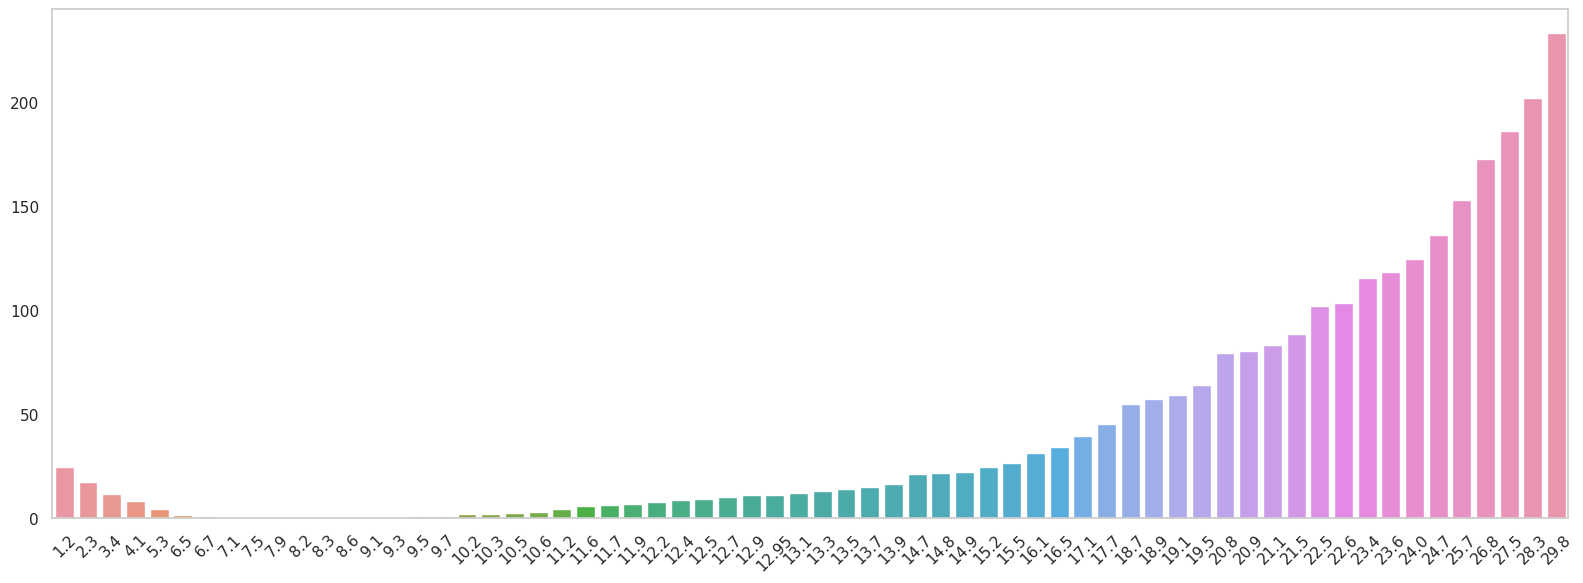

In [10]:
fig, axs = plt.subplots(1, 1, figsize = (16, 6))
bins_value  = np.arange(1, 31, 1)
plt1 = sns.barplot(x = ytrue.detach().cpu().numpy().ravel(), y = np.array(C_ij[:, 0, 0]),  ax = axs)
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)
None

In [11]:
blur = 0.01
nits = 100

# Setup the dual variables -------------------------------------------------
eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
F_i, G_j = torch.zeros_like(loga_i), torch.zeros_like(
    logb_j
)  # (scaled) dual vectors

# Sinkhorn loop = coordinate ascent on the dual maximization problem -------
for _ in range(nits):
    F_i = -((-C_ij / eps + (G_j + logb_j))).logsumexp(dim=1)[:, None, :]
    G_j = -((-C_ij / eps + (F_i + loga_i))).logsumexp(dim=0)[None, :, :]

# Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
F_i_out, G_j_out = eps * F_i, eps * G_j
F_i, G_j = F_i_out.view(-1), G_j_out.view(-1)

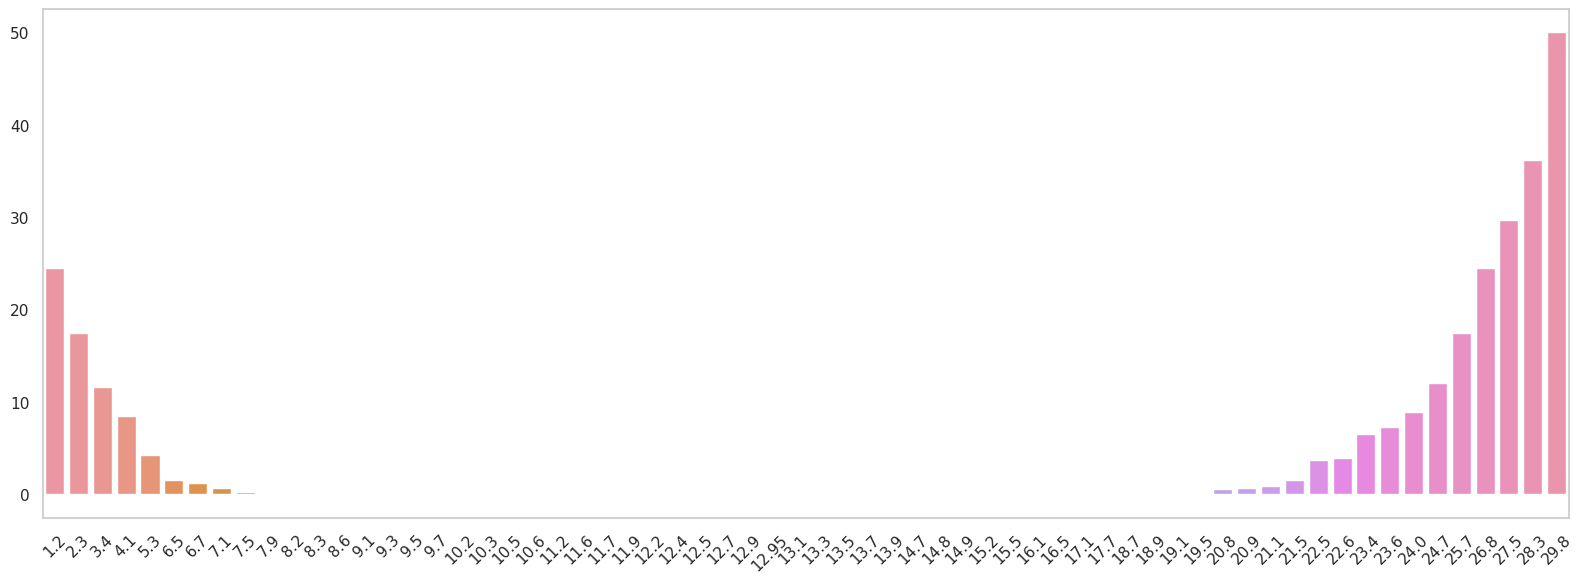

In [12]:
fig, axs = plt.subplots(1, 1, figsize = (16, 6))
bins_value  = np.arange(1, 31, 1)
plt1 = sns.barplot(x = ytrue.detach().cpu().numpy().ravel(), y = np.array(F_i),  ax = axs)
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)
None

In [13]:
# Returns the entropic transport cost associated to the dual variables F_i and G_j.''ArithmeticError
entropic_transport_cost = ytrue_w.dot(F_i) + ypred_w.dot(G_j)
wasserstein_distance = (2 * entropic_transport_cost).sqrt()
wasserstein_distance

tensor(56.6439, dtype=torch.float64)

### Let's try without Weights

In [19]:
ytrue_w2 = torch.full((64,), 1/64) # a constant value chosen for each sample based on 1/M or 1/N which M or N is the number of samples
ypred_w2 = torch.full((64,), 1/64) 

# Compute the logarithm of the weights (needed in the softmin reduction) ---
loga_i_2, logb_j_2 = ytrue_w2.log(), ypred_w2.log()
loga_i_2, logb_j_2 = loga_i_2[:, None, None], logb_j_2[None, :, None]

blur = 0.01
nits = 100

# Setup the dual variables -------------------------------------------------
eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
F_i_2, G_j_2 = torch.zeros_like(loga_i_2), torch.zeros_like(
    logb_j_2
)  # (scaled) dual vectors

# Sinkhorn loop = coordinate ascent on the dual maximization problem -------
for _ in range(nits):
    F_i_2 = -((-C_ij / eps + (G_j_2 + logb_j_2))).logsumexp(dim=1)[:, None, :]
    G_j_2 = -((-C_ij / eps + (F_i_2 + loga_i_2))).logsumexp(dim=0)[None, :, :]

# Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
F_i_out2, G_j_out2 = eps * F_i_2, eps * G_j_2
F_i_2, G_j_2 = F_i_out2.view(-1), G_j_out2.view(-1)

# Returns the entropic transport cost associated to the dual variables F_i and G_j.''ArithmeticError
entropic_transport_cost = ytrue_w2.dot(F_i) + ypred_w2.dot(G_j)
wasserstein_distance    = (2 * entropic_transport_cost).sqrt()
wasserstein_distance


tensor(2.9271)

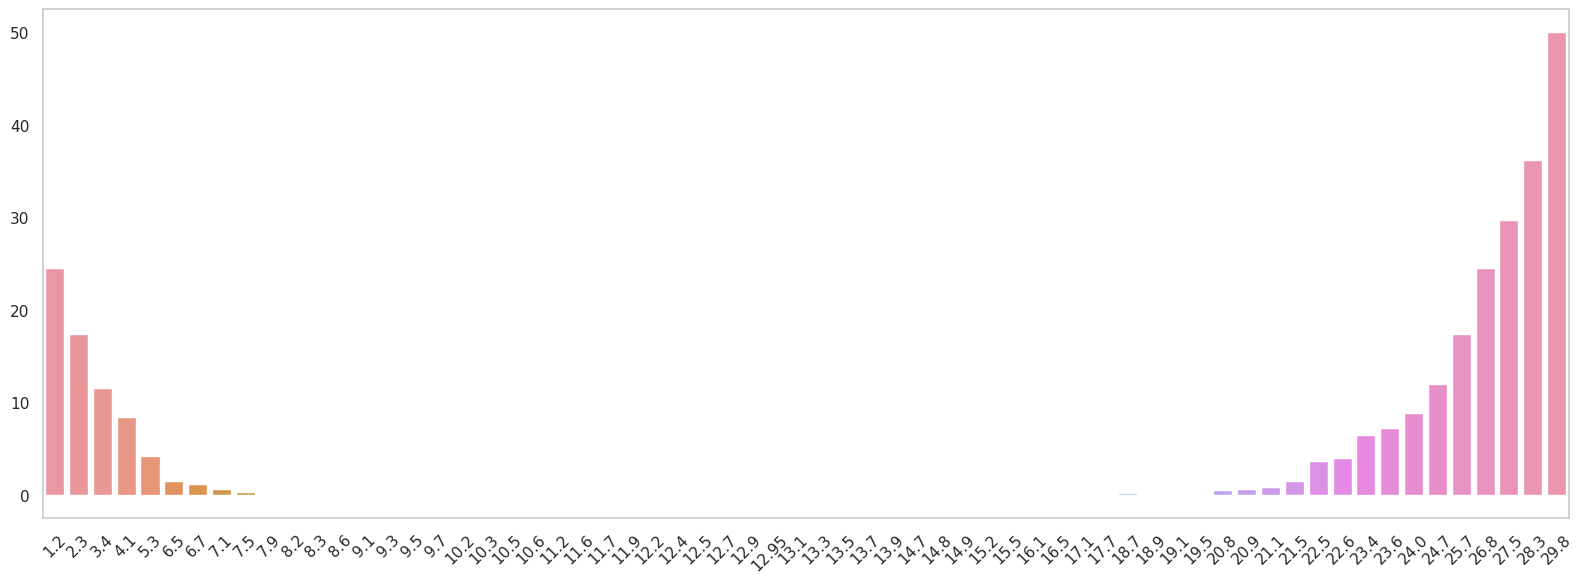

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (16, 6))
bins_value  = np.arange(1, 31, 1)
plt1 = sns.barplot(x = ytrue.detach().cpu().numpy().ravel(), y = np.array(F_i_2),  ax = axs)
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)
None

### Impact of Blur arg

In [42]:

import random 
list_blur = np.arange(0, 1, 0.01) #[1, 0.1, 0.01, 0.001, 0.0001] 

list_w = []
for b in list_blur: 

    ytrue_w2 = torch.full((64,), 1/64) # a constant value chosen for each sample based on 1/M or 1/N which M or N is the number of samples
    ypred_w2 = torch.full((64,), 1/64) 

    # Compute the logarithm of the weights (needed in the softmin reduction) ---
    loga_i_2, logb_j_2 = ytrue_w2.log(), ypred_w2.log()
    loga_i_2, logb_j_2 = loga_i_2[:, None, None], logb_j_2[None, :, None]

    blur = b
    nits = 100

    # Setup the dual variables -------------------------------------------------
    eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
    F_i_2, G_j_2 = torch.zeros_like(loga_i_2), torch.zeros_like(
        logb_j_2
    )  # (scaled) dual vectors

    # Sinkhorn loop = coordinate ascent on the dual maximization problem -------
    for _ in range(nits):
        F_i_2 = -((-C_ij / eps + (G_j_2 + logb_j_2))).logsumexp(dim=1)[:, None, :]
        G_j_2 = -((-C_ij / eps + (F_i_2 + loga_i_2))).logsumexp(dim=0)[None, :, :]

    # Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
    F_i_out2, G_j_out2 = eps * F_i_2, eps * G_j_2
    F_i_2, G_j_2 = F_i_out2.view(-1), G_j_out2.view(-1)

    # Returns the entropic transport cost associated to the dual variables F_i and G_j.''ArithmeticError
    entropic_transport_cost = ytrue_w2.dot(F_i_2) + ypred_w2.dot(G_j_2)
    wasserstein_distance    = (2 * entropic_transport_cost).sqrt()
    list_w.append(wasserstein_distance)
   #print(f"{b} | {wasserstein_distance}")



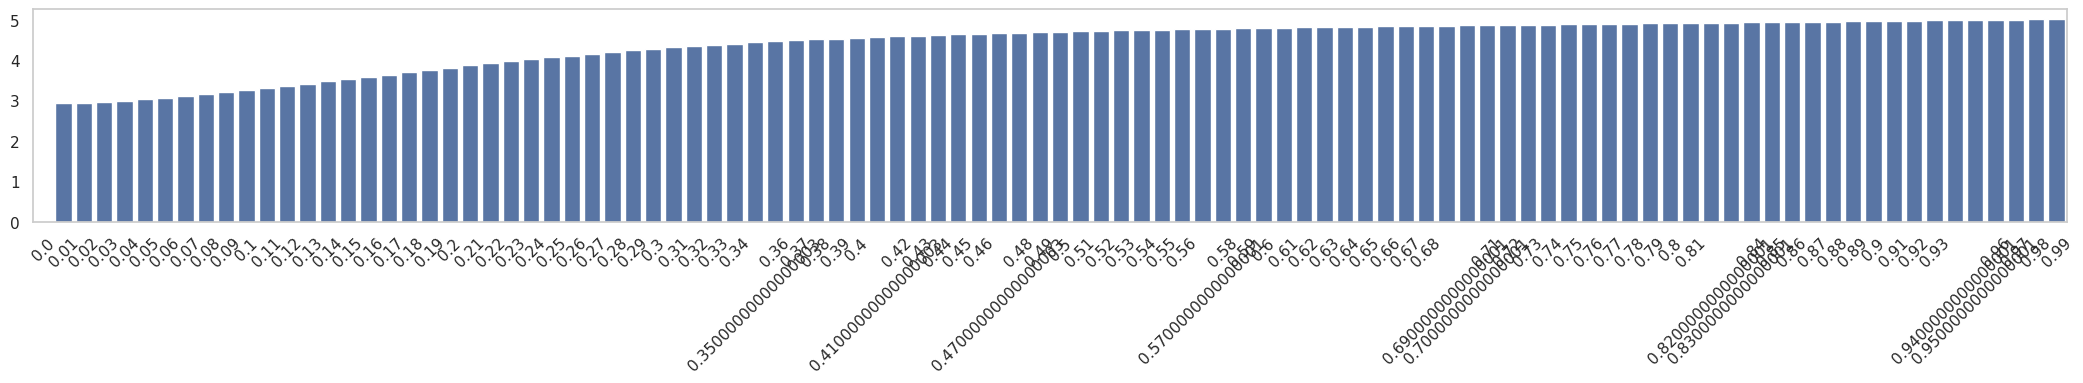

In [43]:
fig, axs = plt.subplots(1, 1 , figsize = (21, 4))

sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams["figure.autolayout"] = True
plt.subplots_adjust(hspace = 0.01)

ax3 = sns.barplot(x = list_blur, y = np.array(list_w), color = sns.color_palette()[0],  ax = axs)
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)
None

In [44]:
import random 
list_blur = np.arange(0, 1, 0.01) #[1, 0.1, 0.01, 0.001, 0.0001] 

list_w = []
for b in list_blur: 

    # Compute the logarithm of the weights (needed in the softmin reduction) ---
    loga_i, logb_j = ytrue_w.log(), ypred_w.log()
    loga_i, logb_j = loga_i[:, None, None], logb_j[None, :, None]

    blur = b
    nits = 100

    # Setup the dual variables -------------------------------------------------
    eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
    F_i, G_j = torch.zeros_like(loga_i), torch.zeros_like(
        logb_j
    )  # (scaled) dual vectors

    # Sinkhorn loop = coordinate ascent on the dual maximization problem -------
    for _ in range(nits):
        F_i = -((-C_ij / eps + (G_j + logb_j))).logsumexp(dim=1)[:, None, :]
        G_j = -((-C_ij / eps + (F_i + loga_i))).logsumexp(dim=0)[None, :, :]

    # Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
    F_i_out, G_j_out = eps * F_i, eps * G_j
    F_i, G_j = F_i_out.view(-1), G_j_out.view(-1)

    # Returns the entropic transport cost associated to the dual variables F_i and G_j.''ArithmeticError
    entropic_transport_cost = ytrue_w.dot(F_i) + ypred_w.dot(G_j)
    wasserstein_distance    = (2 * entropic_transport_cost).sqrt()
    list_w.append(wasserstein_distance)
   #print(f"{b} | {wasserstein_distance}")

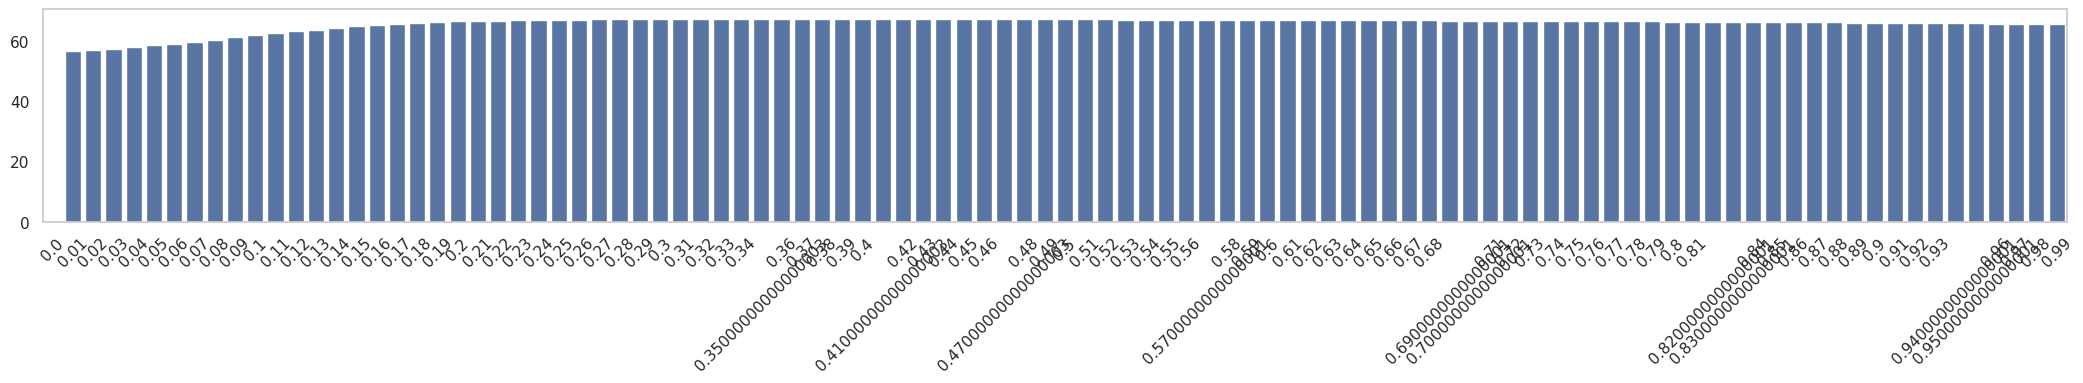

In [45]:
fig, axs = plt.subplots(1, 1 , figsize = (21, 4))

sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams["figure.autolayout"] = True
plt.subplots_adjust(hspace = 0.01)

ax3 = sns.barplot(x = list_blur, y = np.array(list_w), color = sns.color_palette()[0],  ax = axs)
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)
None

### My Crazy idea to change the cost function 

cost $\text{C}(x,y) = (\tfrac{1}{2}\|x-y\|^2)*ytrue_w@ypred_w$

In [51]:
W_true = ytrue_w[:, None]
W_pred = ypred_w[:, None]
D_w = W_true @ W_pred.t()
D_w = D_w[:, :, None]

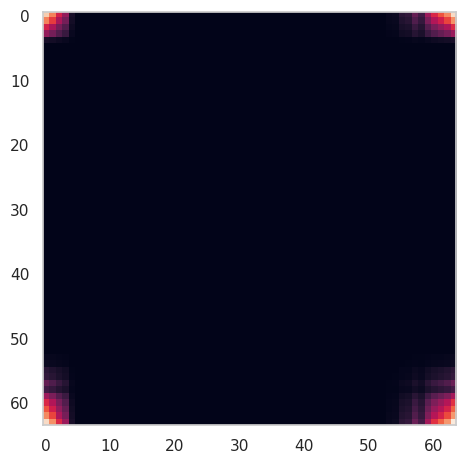

In [52]:
plt.imshow(D_w[:, :, 0])

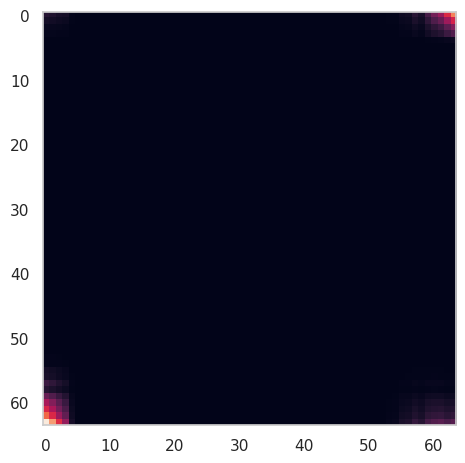

In [54]:
C_ij_New = C_ij*D_w
plt.imshow(C_ij_New[:, :, 0])

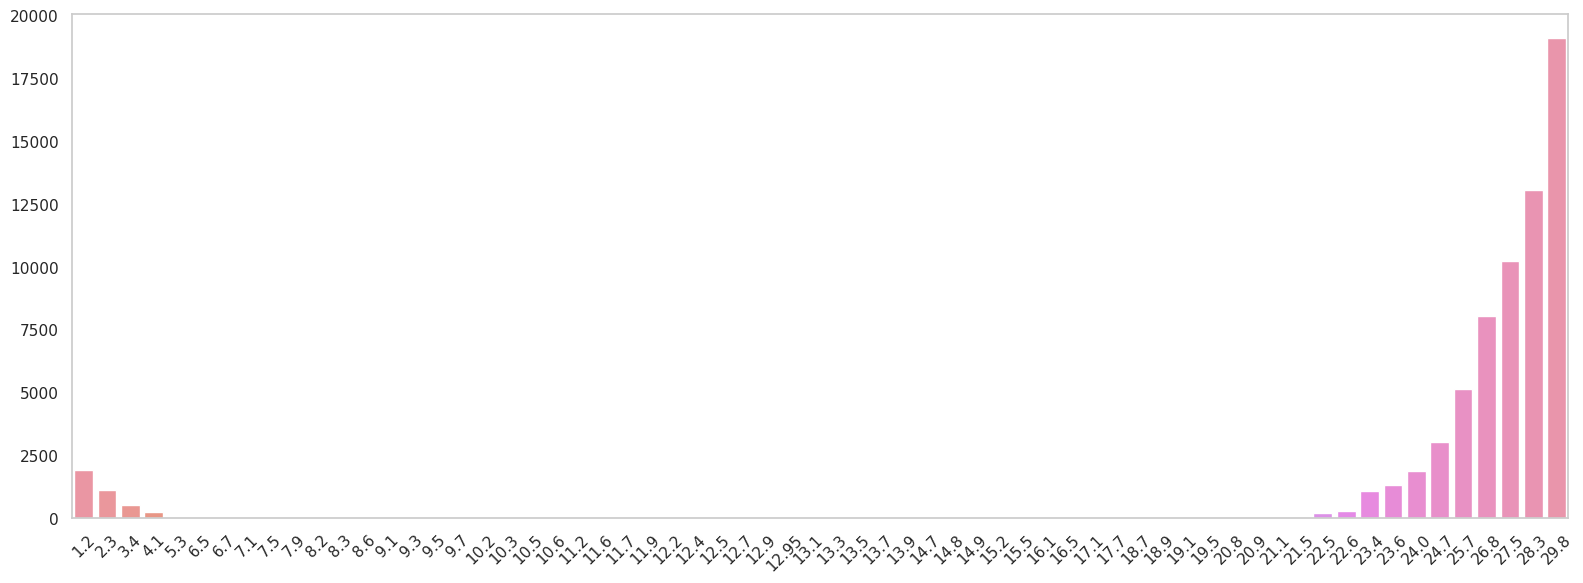

In [57]:
fig, axs = plt.subplots(1, 1, figsize = (16, 6))
bins_value  = np.arange(1, 31, 1)
plt1 = sns.barplot(x = ytrue.detach().cpu().numpy().ravel(), y = np.array(C_ij_New[:, 0, 0]),  ax = axs)
plt.setp(axs.xaxis.get_majorticklabels(), rotation = 45)
None

In [55]:
blur = 0.01
nits = 100

# Setup the dual variables -------------------------------------------------
eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
F_i, G_j = torch.zeros_like(loga_i), torch.zeros_like(
    logb_j
)  # (scaled) dual vectors

# Sinkhorn loop = coordinate ascent on the dual maximization problem -------
for _ in range(nits):
    F_i = -((-C_ij_New / eps + (G_j + logb_j))).logsumexp(dim=1)[:, None, :]
    G_j = -((-C_ij_New / eps + (F_i + loga_i))).logsumexp(dim=0)[None, :, :]

# Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
F_i_out, G_j_out = eps * F_i, eps * G_j
F_i, G_j = F_i_out.view(-1), G_j_out.view(-1)

entropic_transport_cost = ytrue_w.dot(F_i) + ypred_w.dot(G_j)
wasserstein_distance = (2 * entropic_transport_cost).sqrt()
wasserstein_distance

tensor(5.4832, dtype=torch.float64)